### TODO Recording

- Make sure you toggle headers, line numbers, toolbar
- Make sure you change the kernel to mlflow_venv

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression

### Dataset link:
https://www.kaggle.com/datasets/tejashvi14/tour-travels-customer-churn-prediction

Target = 1 customer churns
Target = 0 customer does not churn

In [2]:
travel_churn_data = pd.read_csv('./datasets/customer_travel.csv')

travel_churn_data.head()

Age FrequentFlyer AnnualIncomeClass  ServicesOpted  \
0   34            No     Middle Income              6   
1   34           Yes        Low Income              5   
2   37            No     Middle Income              3   
3   30            No     Middle Income              2   
4   30            No        Low Income              1   

  AccountSyncedToSocialMedia BookedHotelOrNot  Target  
0                         No              Yes       0  
1                        Yes               No       1  
2                        Yes               No       0  
3                         No               No       0  
4                         No               No       0

In [3]:
travel_churn_data.columns

Index(['Age', 'FrequentFlyer', 'AnnualIncomeClass', 'ServicesOpted',
       'AccountSyncedToSocialMedia', 'BookedHotelOrNot', 'Target'],
      dtype='object')

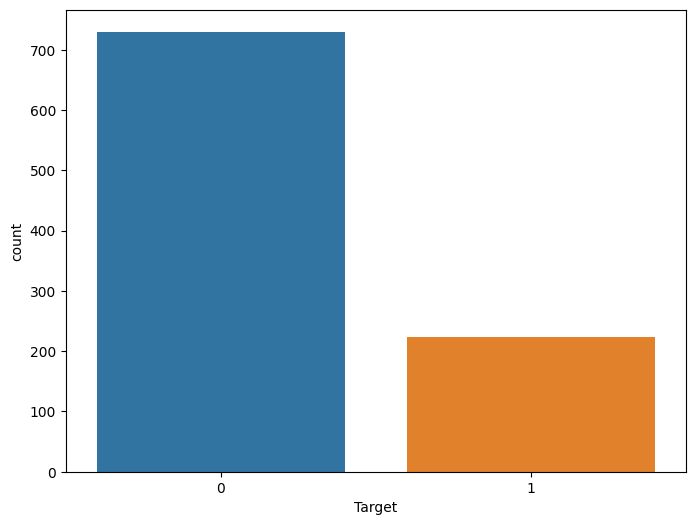

In [4]:
plt.subplots(figsize = (8, 6))

sns.countplot(x = 'Target', data = travel_churn_data)
plt.show()

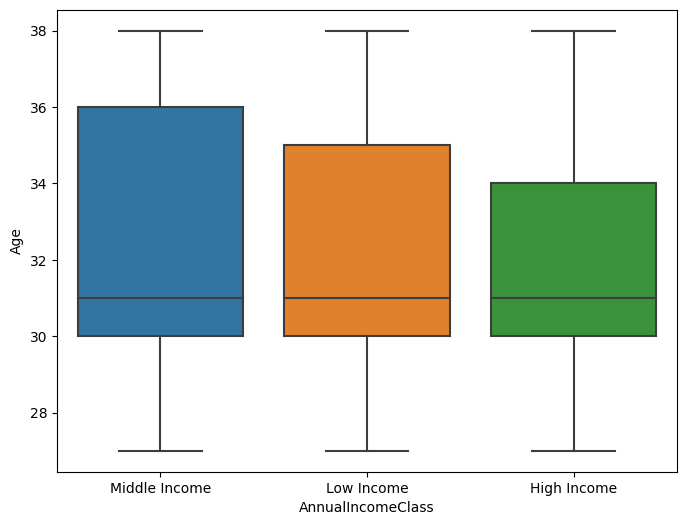

In [5]:
plt.subplots(figsize = (8, 6))

sns.boxplot(x = 'AnnualIncomeClass', y = 'Age', data = travel_churn_data)
plt.show()

In [6]:
travel_churn_data['AnnualIncomeClass'].unique()

array(['Middle Income', 'Low Income', 'High Income'], dtype=object)

In [7]:
mapper = {'Low Income': 0,'Middle Income': 1, 'High Income': 2}

travel_churn_data['AnnualIncomeClass'] = travel_churn_data['AnnualIncomeClass'].replace(mapper)

In [8]:
travel_churn_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Age                         954 non-null    int64 
 1   FrequentFlyer               954 non-null    object
 2   AnnualIncomeClass           954 non-null    int64 
 3   ServicesOpted               954 non-null    int64 
 4   AccountSyncedToSocialMedia  954 non-null    object
 5   BookedHotelOrNot            954 non-null    object
 6   Target                      954 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 52.3+ KB


In [9]:
categorical_features = [
    'FrequentFlyer','AccountSyncedToSocialMedia', 'BookedHotelOrNot']

categorical_transformer = Pipeline(
    steps = [('encoder', OneHotEncoder(handle_unknown = 'ignore', drop = 'first'))])
    
preprocessor = ColumnTransformer(
    transformers = [("cat", categorical_transformer, categorical_features)], 
    remainder = StandardScaler()
)

In [10]:
X = travel_churn_data.drop(labels = ['Target'], axis = 1)
 
y = travel_churn_data['Target']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 124)

In [11]:
X_train.shape, X_test.shape

((763, 6), (191, 6))

In [12]:
import mlflow
import mlflow.sklearn

In [13]:
import mlflow

mlflow.get_tracking_uri()

'file:///Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/mlruns'

### TODO Recording:

- Go to the terminal window under ~/projects/mlflow
- All our notebooks should be here

`ls -l`

- Create an artifacts directory

`mkdir artifacts`

- Make sure it is created

`ls -l`

- Go to the MLflow UI
- Click on the + button to create an experiment
- Call it customer_churn_prediction
- Make sure you specify an artifacts location /Users/Loonycorn/projects/mlflow/artifacts

Note: If artifact location is not specified the current version MLflow has a bug where you will get an error that log_artifact will fail https://github.com/mlflow/mlflow/issues/7819

In [14]:
mlflow.set_experiment(experiment_name = 'customer_churn_prediction')

<Experiment: artifact_location='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts', creation_time=1687314283677, experiment_id='435229069664719161', last_update_time=1687314283677, lifecycle_stage='active', name='customer_churn_prediction', tags={}>

#### Model signature

https://www.mlflow.org/docs/latest/models.html#model-signature

Note that we are not autologging here

Pay close attention to the model signature in the logged artifacts

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from mlflow.models.signature import infer_signature
 
with mlflow.start_run(run_name = 'logistic_model') as logistic_run:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions = pipe_lr.predict(X_test)

    predictions_predict_prob = pipe_lr.predict_proba(X_test)
    
    train_accuracy_score = pipe_lr.score(X_train, y_train)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
    model_params = lr_model.get_params()
    mlflow.log_params(model_params)

    metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score
    }
    
    mlflow.log_metrics(metrics)
    
    # Explicit model signature creation
    from mlflow.models.signature import ModelSignature
    from mlflow.types.schema import Schema, ColSpec
    
    input_schema = Schema(
    [
        ColSpec('long', 'Age'),
        ColSpec('string', 'FrequentFlyer'),
        ColSpec('long', 'AnnualIncomeClass'),
        ColSpec('long', 'ServicesOpted'),
        ColSpec('string', 'AccountSyncedToSocialMedia'),
        ColSpec('string', 'BookedHotelOrNot')
    ]
)
    output_schema = Schema([ColSpec('integer')])
    signature = ModelSignature(inputs = input_schema, outputs = output_schema)


    mlflow.sklearn.log_model(
        pipe_lr, 
        'preprocessing_pipeline_with_logistic_regression_model', 
        signature = signature)
    
    mlflow.set_tag('Classifier', 'logistic regression default parameters')

/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


### TODO Recording

- Go to the MLflow UI
- Click on the churn experiment and the run
- Show everything logged
- Show that the model is serialized with the name we specified
- Click on all the files in the artifacts

#### Model explainability with Shapley values

#### Note: Numpy version should be downgraded to 1.23 for working of shap explanation

https://towardsdatascience.com/introduction-to-shap-values-and-their-application-in-machine-learning-8003718e6827

In [ ]:
pip install shap

##### Warnings

- Input values integer types cannot deal with missing values - we know how to fix this but since our dataset does not contain missing values we can ignore this
- If our training data had missing values in the integer columns that would remove this warning but our training data is clean with no missing values
- Other warnings are internal to the shap library that mlflow uses and we cannot do anything about them


##### Shapley explanations

https://mlflow.org/docs/latest/python_api/mlflow.shap.html#mlflow.shap.log_explanation

In [16]:
import mlflow.shap

with mlflow.start_run(run_name = 'logistic model with explanation') as logistic_run:
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =   pipe_lr.predict_proba(X_test)
    
    train_accuracy_score =   pipe_lr.score(X_train, y_train)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    
    model_params = lr_model.get_params()
    mlflow.log_params(model_params)

    metrics = {
        'Train_accuracy_score': train_accuracy_score, 
        'Test_accuracy_score': test_accuracy_score,
        'Test_precision_score': test_precision_score,
        'Test_recall_score': test_recall_score,
        'Test_f1_score': test_f1_score,
        'AUC_score': auc_score 
    }
    
    mlflow.log_metrics(metrics)
    
    # Infer the signature based on the training data
    signature = infer_signature(X_train, pipe_lr.predict(X_train))
    
    # Compute Shapley values
    observations =  pipe_lr.named_steps['preprocessor'].transform(X_train)
    
    observations_asframe =  pd.DataFrame(
        observations , columns = preprocessor.get_feature_names_out())
    
    print(observations_asframe)
    
    mlflow.shap.log_explanation(
        pipe_lr.named_steps['classifier'].predict, observations_asframe)

    mlflow.sklearn.log_model(
        pipe_lr, 
        'preprocessing_pipeline_with_logistic_regression_model', 
        signature = signature
    )
    
    mlflow.set_tag('Classifier', 'logistic regression default parameters')
    mlflow.set_tag('Explanation', 'true')

/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/models/signature.py:144: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)
/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/shap/utils/_cluste

     cat__FrequentFlyer_No Record  cat__FrequentFlyer_Yes  \
0                             0.0                     0.0   
1                             0.0                     0.0   
2                             0.0                     0.0   
3                             0.0                     0.0   
4                             0.0                     0.0   
..                            ...                     ...   
758                           0.0                     1.0   
759                           0.0                     0.0   
760                           0.0                     1.0   
761                           0.0                     0.0   
762                           0.0                     0.0   

     cat__AccountSyncedToSocialMedia_Yes  cat__BookedHotelOrNot_Yes  \
0                                    1.0                        0.0   
1                                    1.0                        0.0   
2                                    0.0              

  0%|          | 0/763 [00:00<?, ?it/s]

### TODO Recording

- Go to the UI
- Click on the latest run logistic model with explanation
- Go straight to the artifacts

- Show that we have the serialized model artifacts preprocessing_pipeline_with_logistic_regression_mode
- Click on the MLModel file and show that the signature has been inferred
- Select the model_explanations_shap folder and select each item under it
- The summary_bar_plot.png will contain model explanations

##### Notes

Shap values are the explanations for each prediction. e.g. shap_values[0] will be the explainer for the first prediction and so on

In [23]:
import os
from mlflow import MlflowClient

client = MlflowClient()

artifact_path = 'model_explanations_shap'

artifacts = [
    x.path for x in client.list_artifacts(
        logistic_run.info.run_id, artifact_path)
]

print('# artifacts:')
print(artifacts)

# Load back the logged explanation
dst_path = mlflow.artifacts.download_artifacts(run_id = logistic_run.info.run_id)

dst_path = os.path.join(dst_path, artifact_path)

print(dst_path)

base_values = np.load(os.path.join(dst_path, 'base_values.npy'))
shap_values = np.load(os.path.join(dst_path, 'shap_values.npy'))

print('\n# base_values:')
print(base_values)
print('\n# shap_values:')
print(shap_values)

# artifacts:
['model_explanations_shap/base_values.npy', 'model_explanations_shap/shap_values.npy', 'model_explanations_shap/summary_bar_plot.png']
/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts/7b5e906c992f4b0fb5c5390d92cec8a7/artifacts/model_explanations_shap

# base_values:
0.1743119266055046

# shap_values:
[[ 0.         -0.10913062  0.01876365 ... -0.090782    0.00115771
  -0.00974225]
 [ 0.         -0.2469419   0.0249017  ...  0.04390564  0.00115771
  -0.01998689]
 [ 0.         -0.22612495 -0.00659677 ...  0.04768458 -0.00279598
  -0.00875928]
 ...
 [ 0.          0.51922237  0.03964613 ...  0.14525994 -0.00478375
  -0.04250765]
 [ 0.         -0.10561381 -0.01452599 ... -0.07317606 -0.00229358
   0.00567934]
 [ 0.         -0.19938838  0.03149847 ...  0.05858453 -0.00183486
  -0.0129751 ]]


Now we are enabling autologging.Note that auc_score is not autologged.So we need to log it using 'log_metric', everything else is autologged

#### Train a number of different models 

- We'll pick a "best" one based on evaluation metrics to load and use for predictions

In [24]:
mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'logistic model with autologging'):
 
    lr_model = LogisticRegression()
    
    pipe_lr = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', lr_model)])
    pipe_lr.fit(X_train, y_train)
 
    predictions =  pipe_lr.predict(X_test)
    predictions_predict_prob =  pipe_lr.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    # Needs to be logged explicitly since it is not autologged
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train,  pipe_lr.predict(X_train))
 
    mlflow.set_tag('Classifier', 'logistic regression default parameters')

2023/06/21 08:04:17 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['FrequentFlyer', 'AccountSyncedToSocialMedia',
                                  'BookedHotelOrNot'])])), ('classifier', Logist...`
2023/06/21 08:04:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

### TODO Recording

- Go to the MLflow UI
- Click on the "logistic model with autologging"
- Metrics section: Show that there are so many metrics that are autologged
- Artifacts section: Click on the png files that have the graphs

In [25]:
mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'random forest model default parameters'):
 
    rf_model = RandomForestClassifier()
    
    pipe_rf = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', rf_model)])
    pipe_rf.fit(X_train, y_train)
 
    predictions =  pipe_rf.predict(X_test)
    predictions_predict_prob = pipe_rf.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
      
    signature = infer_signature(X_train, pipe_rf.predict(X_train))
 
    mlflow.set_tag('Classifier', 'random forest default parameters')

2023/06/21 08:04:34 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['FrequentFlyer', 'AccountSyncedToSocialMedia',
                                  'BookedHotelOrNot'])])), ('classifier', Random...`
2023/06/21 08:04:34 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

In [26]:
# Does not support prediction probability
from sklearn.svm import SVC

mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'SVC model default parameters'):
 
    svc_model = SVC()
    
    pipe_svc = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', svc_model)])
    pipe_svc.fit(X_train, y_train)
 
    predictions =  pipe_svc.predict(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    signature = infer_signature(X_train, pipe_svc.predict(X_train))
 
    mlflow.set_tag('Classifier', 'SVC default parameters')

2023/06/21 08:04:39 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/06/21 08:04:39 WARNING mlflow.utils.autologging_utils: MLflow auto

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

mlflow.sklearn.autolog()

# Need to re-import these after turning on autolog
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

with mlflow.start_run(run_name = 'gradient boosting model default parameters'):
 
    gb_model = GradientBoostingClassifier()
    
    pipe_gb = Pipeline(steps = [('preprocessor', preprocessor), ('classifier', gb_model)])
    pipe_gb.fit(X_train, y_train)
    
    predictions =  pipe_gb.predict(X_test)
    predictions_predict_prob = pipe_gb.predict_proba(X_test)
    
    test_accuracy_score = accuracy_score(y_test, predictions)
    test_precision_score = precision_score(y_test, predictions)
    test_recall_score = recall_score(y_test, predictions)
    test_f1_score = f1_score(y_test, predictions)
    
    auc_score = roc_auc_score(y_test,  predictions_predict_prob[:, 1])
    mlflow.log_metric('AUC_score', auc_score)
    
    signature = infer_signature(X_train, pipe_gb.predict(X_train))
 
    mlflow.set_tag('Classifier', 'gradient boosting default parameters')

2023/06/21 08:04:45 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(remainder=StandardScaler(),
                  transformers=[('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'))]),
                                 ['FrequentFlyer', 'AccountSyncedToSocialMedia',
                                  'BookedHotelOrNot'])])), ('classifier', Gradie...`
2023/06/21 08:04:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

### TODO Recording


- Go to the UI
- Select columns and add AUC_score and f1_scoreX_test
- Select the last 4 runs (logistic with autologging, random forest, SVC and gradient boosting)
- Click on Compare
- In the Parallel Coordinates Plot
- ----- Parameters: Classifier
- ----- Metrics: training_score, f1_score_X_test, accuracy_score_X_test
- Show the plot
- Scroll and show the other differences


In [28]:
client = mlflow.tracking.MlflowClient()
experiments_list = client.search_experiments()
 
experiments_list

[<Experiment: artifact_location='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts', creation_time=1687314283677, experiment_id='435229069664719161', last_update_time=1687314283677, lifecycle_stage='active', name='customer_churn_prediction', tags={}>,
 <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1687314218909, experiment_id='0', last_update_time=1687314218909, lifecycle_stage='active', name='Default', tags={}>]

Listing all experiments

In [29]:
experiment = mlflow.get_experiment_by_name(experiments_list[0].name)
 
experiment

<Experiment: artifact_location='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts', creation_time=1687314283677, experiment_id='435229069664719161', last_update_time=1687314283677, lifecycle_stage='active', name='customer_churn_prediction', tags={}>

### TODO Recording

- Let's show what exactly we are doing below
- Head over to the UI
- Select any model run (e.g gradient boosting)
- Click through and show the artifacts
- Make sure you have the model/ folder selected
- Show the code that we can use to load the model and get predictions
- Back here in the notebook this is what we are going to use

We are first choosing Accuracy score on test set as criteria for choosing best model

In [30]:
df_run_metrics = mlflow.search_runs(
    [experiment.experiment_id], order_by = ['metrics.accuracy_score_X_test DESC'])
 
df_run_metrics[['run_id', 'tags.Classifier', 'metrics.accuracy_score_X_test']]

run_id                         tags.Classifier  \
0  990e1d9429a849e6aa64e526ee4b7349    gradient boosting default parameters   
1  9305f49b0d1643e8b62e8cafb9082cd8        random forest default parameters   
2  f12ec6b21bb94e2ba6981431ca46f938                  SVC default parameters   
3  4fa65afbc5184a9a9a64143b86efe4ea  logistic regression default parameters   
4  7b5e906c992f4b0fb5c5390d92cec8a7  logistic regression default parameters   
5  064fdbe98bd34283ba75e15d29f0cca0  logistic regression default parameters   

   metrics.accuracy_score_X_test  
0                       0.858639  
1                       0.853403  
2                       0.785340  
3                       0.743455  
4                            NaN  
5                            NaN

Best run id is obtained

In [31]:
best_run_id = df_run_metrics.loc[0, 'run_id']
 
best_run_id

'990e1d9429a849e6aa64e526ee4b7349'

Classifier name and Run names are extracted (the best model happens to be the RF model)

In [32]:
print('Classifier_name :', df_run_metrics.loc[0, 'tags.Classifier'])
 
print('Run_name :', df_run_metrics.loc[0, 'tags.mlflow.runName'])

Classifier_name : gradient boosting default parameters
Run_name : gradient boosting model default parameters


Model uri is obtained

In [33]:
model_uri = 'runs:/' + best_run_id + '/model'
 
model_uri

'runs:/990e1d9429a849e6aa64e526ee4b7349/model'

Loading our best model using mlflow.sklearn

In [34]:
import mlflow.sklearn
 
best_model = mlflow.sklearn.load_model(model_uri = model_uri)

best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['FrequentFlyer',
                                                   'AccountSyncedToSocialMedia',
                                                   'BookedHotelOrNot'])])),
                ('classifier', GradientBoostingClassifier())])

### TODO Recording:

- Expand the pipeline and show each step

Loaded model is used for predictions - compare with original model

## IMPORTANT: Please check that the best model is indeed the GB model or update the pipeline used accordingly

In [35]:
predictions_loaded = best_model.predict(X_test)
 
predictions_loaded

array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [36]:
predictions_original = pipe_gb.predict(X_test)
 
predictions_original

2023/06/21 08:05:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/mlflow_venv/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


array([0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [37]:
assert(np.array_equal(predictions_loaded, predictions_original))

We are doing Model Registration using best run id based on accuracy metric.

In [38]:
model_name = 'churn_prediction_model'
 
model_version = mlflow.register_model(f'runs:/{best_run_id}/model', model_name)

Successfully registered model 'churn_prediction_model'.
2023/06/21 08:05:27 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_model, version 1
Created version '1' of model 'churn_prediction_model'.


### TODO Recording

- Go the MLflow UI
- Click through to the best model (GB)
- Select models/ under Artifacts - show that the model has been registered
- Click on the Models tab on top (next to Experiments)
- Show the churn prediction model version 1 there
- Click through to the model
- Click through to Version 1
- Show Inputs and Outputs

#### Change the stage

- Click on the Stage at the top of the version page and transition the model to "Staging"

In [39]:
from mlflow.tracking import MlflowClient
 
client = MlflowClient()

client.get_model_version_stages(name = model_name, version = model_version.version)

['None', 'Staging', 'Production', 'Archived']

In [40]:
client.transition_model_version_stage(
  name = model_name,
  version = model_version.version,
  stage = 'Production',
)

<ModelVersion: aliases=[], creation_timestamp=1687314927834, current_stage='Production', description=None, last_updated_timestamp=1687314936540, name='churn_prediction_model', run_id='990e1d9429a849e6aa64e526ee4b7349', run_link=None, source='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts/990e1d9429a849e6aa64e526ee4b7349/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

### TODO Recording:

- Go to the MLflow UI
- Go to Models
- Click through to the Churn model and show that it is in production

Now the model can be loaded from any stage by using 'pyfunc.load_model' and accuracy score on test set can be obtained which is same as seen in the metrics obtained for the particular run.

The warning here is not really a warning because we are on mlflow 2.3.2(we'll see why that warning shows up in just a bit)

In [41]:
model_name = 'churn_prediction_model'
stage = 'Production'
 
loaded_model = mlflow.pyfunc.load_model(
    model_uri = f'models:/{model_name}/{stage}'
)
 
print(f'F1 score: {f1_score(y_test, loaded_model.predict(X_test))}')

2023/06/21 08:05:52 WARNING mlflow.pyfunc: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 2.4.1, required: mlflow==2.4)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


F1 score: 0.6582278481012659


In [42]:
df_run_metrics.loc[0, 'metrics.f1_score_X_test']

0.6582278481012659

### TODO Recording

- Go to the UI
- Go to the page for Version 1
- On the top-right click on the Source Run associated with this model "gradient boosting model default parameters"
- Click on the MLmodel file - MLflow version should be 2.3.2
- Click on the conda.yaml file which sets up the env for the model - version is 2.3
- Click on the requirements.txt file which sets up the pip env - version is 2.3
- This is why we get the warning

If we consider recall score as the metrics for choosing model, Then we can move the best run in terms of recall score to Production

In [43]:
best_run_recall_metrics = mlflow.search_runs(
    [experiment.experiment_id], order_by = ['metrics.recall_score_X_test DESC'])
 
best_run_recall_metrics[['run_id', 'tags.Classifier', 'metrics.recall_score_X_test']]

run_id                         tags.Classifier  \
0  9305f49b0d1643e8b62e8cafb9082cd8        random forest default parameters   
1  990e1d9429a849e6aa64e526ee4b7349    gradient boosting default parameters   
2  f12ec6b21bb94e2ba6981431ca46f938                  SVC default parameters   
3  4fa65afbc5184a9a9a64143b86efe4ea  logistic regression default parameters   
4  7b5e906c992f4b0fb5c5390d92cec8a7  logistic regression default parameters   
5  064fdbe98bd34283ba75e15d29f0cca0  logistic regression default parameters   

   metrics.recall_score_X_test  
0                     0.744186  
1                     0.604651  
2                     0.372093  
3                     0.209302  
4                          NaN  
5                          NaN

In [44]:
print('Classifier_name :', best_run_recall_metrics.loc[0, 'tags.Classifier'])
 
print('Run_name :', best_run_recall_metrics.loc[0, 'tags.mlflow.runName'])
 
print('Best recall score :', best_run_recall_metrics.loc[0, 'metrics.recall_score_X_test'])

Classifier_name : random forest default parameters
Run_name : random forest model default parameters
Best recall score : 0.7441860465116279


#### Note that a new version of the existing model is created

In [45]:
best_recall_model = mlflow.register_model(
    f"runs:/{best_run_recall_metrics.loc[0, 'run_id']}/model", 
    model_name
)

Registered model 'churn_prediction_model' already exists. Creating a new version of this model...
2023/06/21 08:06:06 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: churn_prediction_model, version 2
Created version '2' of model 'churn_prediction_model'.


### TODO Recording:

- Go to the UI
- Click on MOdels
- Show that the latest version is 2
- Click through to version 2 and show

Model's version specific description can be updated by using 'update_model_version'

In [46]:
client.update_model_version(
    name = 'churn_prediction_model',
    version = 2,
    description = 'This model had the best recall score'
)

<ModelVersion: aliases=[], creation_timestamp=1687314966915, current_stage='None', description='This model had the best recall score', last_updated_timestamp=1687314972507, name='churn_prediction_model', run_id='9305f49b0d1643e8b62e8cafb9082cd8', run_link=None, source='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts/9305f49b0d1643e8b62e8cafb9082cd8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

In [47]:
client.update_model_version(
    name = 'churn_prediction_model',
    version = 1,
    description = 'This model had the best accuracy score '
)

<ModelVersion: aliases=[], creation_timestamp=1687314927834, current_stage='Production', description='This model had the best accuracy score ', last_updated_timestamp=1687314972712, name='churn_prediction_model', run_id='990e1d9429a849e6aa64e526ee4b7349', run_link=None, source='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts/990e1d9429a849e6aa64e526ee4b7349/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=1>

### TODO Recording

- Go to the UI -> Models
- Show that both versions now have meaningful descriptions
- Click through to version 1 (GBM)
- Transition it to Archive

Move the new model (RF) to production

In [48]:
client.transition_model_version_stage(
  name = model_name,
  version = 2,
  stage = 'Production'
)

<ModelVersion: aliases=[], creation_timestamp=1687314966915, current_stage='Production', description='This model had the best recall score', last_updated_timestamp=1687314976050, name='churn_prediction_model', run_id='9305f49b0d1643e8b62e8cafb9082cd8', run_link=None, source='/Users/vitthalsrinivasan/Desktop/iMovieLibrary/Skillsoft/MLOps/MLFlow/final_code/demo_02_ModelRegistrationDeployment/artifacts/9305f49b0d1643e8b62e8cafb9082cd8/artifacts/model', status='READY', status_message=None, tags={}, user_id=None, version=2>

### TODO Recording:

- Go to the UI -> Models
- Show that both versions are in different stages
- Version 1: Archive Version 2: Production

### Serving models locally

In [49]:
best_run_recall_metrics.loc[0, 'run_id']

'9305f49b0d1643e8b62e8cafb9082cd8'

### TODO Recording:

- Switch to the terminal window in the venv
- Make sure that you are in the ~/projects/mlflow folder
- Run

`ls -l`

- You should see a folder for the best run from the cell above
- Serve the model locally (make sure to replace the right run id)

`mlflow models serve -m runs:/<run_id>/model --env-manager local --host 127.0.0.1:1234`

- Now open up a new tab

`curl -X POST -H "Content-Type:application/json" --data '{"dataframe_split": {"columns":["Age","FrequentFlyer","AnnualIncomeClass","ServicesOpted","AccountSyncedToSocialMedia","BookedHotelOrNot"],"data":[[35,"Yes",2,1,"No","No"]]}}' http://127.0.0.1:1234/invocations`

- Wait for a bit - should get prediction 1

`curl -X POST -H "Content-Type:application/json" --data '{"dataframe_split": {"columns":["Age","FrequentFlyer","AnnualIncomeClass","ServicesOpted","AccountSyncedToSocialMedia","BookedHotelOrNot"],"data":[[23,"No",1,0,"No","No"]]}}' http://127.0.0.1:1234/invocations`


- Wait for a bit - should get prediction 0
